# Project: Text Classification

Goal: to build a text classification model on song lyrics and to predict the artist from a piece of text.  
Lyrics dataset: all songs of Radiohead and Arctic Monkeys

Tasks:
- download a HTML page with links to songs
- extract hyperlinks of song pages
- download and extract the song lyrics
- vectorize the text using the Bag Of Words method
- train a classification model that predicts the artist from a piece of text
- refactor the code into functions
- write a simple command-line interface for the program

In [300]:
import pandas as pd
import numpy as np
import string
import requests
import re
from bs4 import BeautifulSoup
from lxml import html
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss

import nltk
from nltk.probability import FreqDist
from nltk import word_tokenize
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
from collections import defaultdict
from pymorphy2 import MorphAnalyzer
from collections import Counter
from nltk.util import ngrams

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

import spacy
import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import warnings
warnings.filterwarnings("ignore")

## Scraping

In [2]:
# use the requests module to download the page listing all songs of the artists
arctic = requests.get('https://www.lyrics.com/artist/Arctic-Monkeys/744567')
radio = requests.get('https://www.lyrics.com/artist/Radiohead/41092')

In [3]:
# save the pages to a text files 
with open('arctic.html', 'w', encoding='utf-8') as file:
    file.write(arctic.text)
    
with open('radio.html', 'w', encoding='utf-8') as file:
    file.write(radio.text)

"# save the pages to a text files \nwith open('arctic.html', 'w', encoding='utf-8') as file:\n    file.write(arctic.text)\n    \nwith open('radio.html', 'w', encoding='utf-8') as file:\n    file.write(radio.text)"

## Regular Expressions

In [83]:
# extract all links using Regular Expressions
pattern =  "\/lyric\/\d{8}\/[0-9A-Za-z+\/]+" 
radio_links1 = re.findall(pattern, radio.text)
arctic_links1 = re.findall(pattern, arctic.text)
#arctic_links1

In [5]:
# write a loop that goes through all songs URLS
def get_links(url):
    """function returns a list of song links"""
    r = requests.get(url)
    r_soup = BeautifulSoup(r.text, "html.parser")

    link_list = []
    for links in r_soup.find_all(attrs={"class": "tal qx"}):
        for link in links.find_all('a'):
            lyric_link = "https://www.lyrics.com" + links.find("a").get("href")
            link_list.append(lyric_link)
    return link_list

In [270]:
arctic_links = get_links("https://www.lyrics.com/artist/Arctic-Monkeys/744567")
arctic_links

['https://www.lyrics.com/lyric/34972023/Arctic+Monkeys/Star+Treatment',
 'https://www.lyrics.com/lyric/34972022/Arctic+Monkeys/One+Point+Perspective',
 'https://www.lyrics.com/lyric/34972021/Arctic+Monkeys/American+Sports',
 'https://www.lyrics.com/lyric/34972020/Arctic+Monkeys/Tranquility+Base+Hotel+%2B+Casino',
 'https://www.lyrics.com/lyric/34972019/Arctic+Monkeys/Golden+Trunks',
 'https://www.lyrics.com/lyric/34972018/Arctic+Monkeys/Four+Out+of+Five',
 'https://www.lyrics.com/lyric/34972017/Arctic+Monkeys/The+World%27s+First+Ever+Monster+Truck+Front+Flip',
 'https://www.lyrics.com/lyric/34972016/Arctic+Monkeys/Science+Fiction',
 'https://www.lyrics.com/lyric/34972015/Arctic+Monkeys/She+Looks+Like+Fun',
 'https://www.lyrics.com/lyric/34972014/Arctic+Monkeys/Batphone',
 'https://www.lyrics.com/lyric/34972013/Arctic+Monkeys/The+Ultracheese',
 'https://www.lyrics.com/lyric/34972012/Arctic+Monkeys/Star+Treatment',
 'https://www.lyrics.com/lyric/34972011/Arctic+Monkeys/One+Point+Perspect

In [269]:
radio_links = get_links("https://www.lyrics.com/artist/Radiohead/41092")
radio_links

['https://www.lyrics.com/lyric/33903378/Radiohead/Karma+Police',
 'https://www.lyrics.com/lyric/33740754/Radiohead/Daydreaming',
 'https://www.lyrics.com/lyric/34465042/Radiohead/Worrywort',
 'https://www.lyrics.com/lyric/32911902/Radiohead/Burn+the+Witch',
 'https://www.lyrics.com/lyric/32929161/Radiohead/Daydreaming',
 'https://www.lyrics.com/lyric/33446757/Radiohead/Decks+Dark',
 'https://www.lyrics.com/lyric/32929159/Radiohead/Desert+Island+Disk',
 'https://www.lyrics.com/lyric/32929158/Radiohead/Ful+Stop',
 'https://www.lyrics.com/lyric/32911897/Radiohead/Glass+Eyes',
 'https://www.lyrics.com/lyric/32929156/Radiohead/Identikit',
 'https://www.lyrics.com/lyric/32911895/Radiohead/The+Numbers',
 'https://www.lyrics.com/lyric/32911894/Radiohead/Present+Tense',
 'https://www.lyrics.com/lyric/32911893/Radiohead/Tinker+Tailer+Solder+Sailor+Rich+Man+Poor+Man+Beggar+Man+Thief',
 'https://www.lyrics.com/lyric/32929153/Radiohead/Tinker+Tailor+Soldier+Sailor+Rich+Man+Poor+Man+Beggar+Man+Thief

## Parsing

In [8]:
def get_lyrics(song_link):
    """function returns a string with the lyrics"""
    string = ''
    song_html = requests.get(song_link).text
    lyrics_soup = BeautifulSoup(song_html, 'html.parser')
   
    
    for lyrics in lyrics_soup.find_all(attrs={'id': 'lyric-body-text', 'class': 'lyric-body'}):
        #text = lyrics.text.split()
        text = lyrics.text.replace('\r',' ')
        text = lyrics.text.replace('\n',' ')
        text = lyrics.text.replace('\\', '')
        
        for word in text:
            string += word.lower()
    return string

In [9]:
arctic_lyrics=[]
for link in arctic_links:
    arctic_lyrics.append(get_lyrics(link)) 
    
# saving files
for i in arctic_lyrics:
    open("arctic_monkeys_new.txt", "a+").write(i + "\n")

In [10]:
radio_lyrics=[]
for link in radio_links:
    radio_lyrics.append(get_lyrics(link)) 
    
# saving files   
for i in radio_lyrics:
    open("radiohead_new.txt", "a+").write(i + "\n")

In [273]:
# combine lyrics
corpus = arctic_lyrics + radio_lyrics
corpus

["i just wanted to be one of the strokes\r\nnow look at the mess you made me make\r\nhitchhiking with a monogrammed suitcase\r\nmiles away from any half-useful imaginary highway\r\ni'm a big name in deep space\r\nask your mates but golden boy's in bad shape\r\ni found out the hard way\r\nthat here ain't no place for dolls like you and me\r\neverybody's on a barge\r\nfloating down the endless stream of great tv\r\n1984, 2019\r\n\r\nmaybe i was a little too wild in the 70s\r\nrocket-ship grease down the cracks of my knuckles\r\nkarate bandana\r\nwarp speed chic\r\nhair down to there\r\nimpressive moustache\r\nlove came in a bottle with a twist off cap\r\nlet's all have a swig and do a hot lap\r\n\r\nso who you gonna call?\r\nthe martini police\r\nbaby, that isn't how they look tonight, oh no\r\nit took the light forever to get to your eyes\r\n\r\ni just wanted to be one of those ghosts\r\nyou thought that you could forget\r\nand then i haunt you via the rear view mirror\r\non a long driv

In [13]:
len(arctic_lyrics), len(radio_lyrics)

(363, 2119)

In [19]:
df1=pd.DataFrame({'songs':artic_lyrics, 'artist':"Arctic Monkeys"})
df1

,songs,artist
0,want stroke \r\n look mess \r\n hitchhike mono...,Arctic Monkeys
1,dance underpant \r\n go to run government \r\n...,Arctic Monkeys
2,gaze planet earth outer space \r\n wipe stupid...,Arctic Monkeys
3,,Arctic Monkeys
4,night psyche \r\n subcommittee sing scary voic...,Arctic Monkeys
...,...,...
358,sketchead come party \n walk drive swinge key ...,Arctic Monkeys
359,marry matador weather girl \n clever girl stan...,Arctic Monkeys
360,fight sheet \r\n nearly cry sleep \r\n yes bat...,Arctic Monkeys
361,mirror image \r\n tell home time \r\n finish \...,Arctic Monkeys


In [20]:
df2=pd.DataFrame({'songs':radio_lyrics, 'artist':"Radiohead"})
df2

,songs,artist
0,karma police \r\n arrest man \r\n talk math \r...,Radiohead
1,dreamer \r\n learn \r\n learn \r\n point \r\n ...,Radiohead
2,wanna talk \r\n wanna word \r\n try hook \r\n ...,Radiohead
3,stay shadow \r\n cheer gallow \r\n round \r\n\...,Radiohead
4,dreamer \r\n learn \r\n learn \r\n point \r\n ...,Radiohead
...,...,...
2114,,Radiohead
2115,heart like landfill \r\n job slowly kill \r\n ...,Radiohead
2116,,Radiohead
2117,,Radiohead


In [21]:
df=pd.concat([df1,df2])
df

,songs,artist
0,want stroke \r\n look mess \r\n hitchhike mono...,Arctic Monkeys
1,dance underpant \r\n go to run government \r\n...,Arctic Monkeys
2,gaze planet earth outer space \r\n wipe stupid...,Arctic Monkeys
3,,Arctic Monkeys
4,night psyche \r\n subcommittee sing scary voic...,Arctic Monkeys
...,...,...
2114,,Radiohead
2115,heart like landfill \r\n job slowly kill \r\n ...,Radiohead
2116,,Radiohead
2117,,Radiohead


In [22]:
df = df[df['artist'].isin(['Arctic Monkeys', 'Radiohead'])]

In [23]:
df.reset_index(inplace=True)
df= df.drop(["index"], axis=1)

In [88]:
# remove spaces and numbers
def clean_text(text):
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r'\n', '', text)
    return text

In [89]:
df['songs']=df['songs'].astype("string")
df['songs'] = df['songs'].apply(clean_text)
df['songs']

0       want stroke \r look mess \r hitchhike monogram...
1       dance underpant \r go to run government \r go ...
2       gaze planet earth outer space \r wipe stupid l...
3                                                        
4       night psyche \r subcommittee sing scary voice ...
                              ...                        
2477                                                     
2478    heart like landfill \r job slowly kill \r brui...
2479                                                     
2480                                                     
2481    want  want explode  floatin surface bird  bird...
Name: songs, Length: 2482, dtype: object

In [26]:
dpl = df.duplicated(subset=["songs"])
df[dpl == False]

df.dropna(subset = ["songs"], inplace=True)

,songs,artist
0,want stroke \r look mess \r hitchhike monogram...,Arctic Monkeys
1,dance underpant \r go to run government \r go ...,Arctic Monkeys
2,gaze planet earth outer space \r wipe stupid l...,Arctic Monkeys
3,,Arctic Monkeys
4,night psyche \r subcommittee sing scary voice ...,Arctic Monkeys
...,...,...
2453,way let way bear light bear light wind rus...,Radiohead
2455,come end start come end belong will eye ball...,Radiohead
2457,jump week bet think pretty clever boy fly mo...,Radiohead
2460,want friend want lover matter end matter st...,Radiohead


In [93]:
mystem = Mystem() 
english_stopwords = stopwords.words("english")
#english_stopwords.remove('yeah')

def preprocess_text(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in english_stopwords\
              and token != " " \
              and token.strip() not in punctuation+'«»“•' \
              and '\n' not in token]
    
    text = " ".join(tokens)
    
    return text

In [281]:
df.songs = df.songs.apply(preprocess_text)
df.head(2)

,songs,artist
0,want stroke look mess hitchhike monogrammed su...,Arctic Monkeys
1,dance underpant go run government go form cove...,Arctic Monkeys


In [275]:
# most frequent words
text = ' '.join(df['songs'].values)
text_trigrams = [i for i in ngrams(text.split(' '), 5)]
text_trigrams
my_list = Counter(text_trigrams).most_common(50)
my_list[:20]

[(('raindrop', 'raindrop', 'raindrop', 'raindrop', 'raindrop'), 258),
 (('special', 'creep', 'weirdo', 'hell', 'belong'), 195),
 (('run', 'run', 'run', 'run', 'run'), 149),
 (('right', 'place', 'right', 'place', 'right'), 148),
 (('place', 'right', 'place', 'right', 'place'), 148),
 (('uptight', 'uptight', 'uptight', 'uptight', 'uptight'), 133),
 (('alarm', 'surprise', 'alarm', 'surprise', 'alarm'), 132),
 (('surprise', 'alarm', 'surprise', 'alarm', 'surprise'), 132),
 (('leave', 'high', 'leave', 'dry', 'leave'), 132),
 (('high', 'leave', 'dry', 'leave', 'high'), 132),
 (('leave', 'dry', 'leave', 'high', 'leave'), 132),
 (('special', 'wish', 'special', 'creep', 'weirdo'), 130),
 (('wish', 'special', 'creep', 'weirdo', 'hell'), 130),
 (('attention', 'payin', 'attention', 'payin', 'attention'), 130),
 (('fuckin', 'special', 'wish', 'special', 'creep'), 128),
 (('da', 'da', 'da', 'da', 'da'), 116),
 (('thing', 'position', 'thing', 'day', 'swallow'), 116),
 (('position', 'thing', 'day', 's

## Vectorization

Tasks:
- Use the CountVectorizer from Scikit to transform your corpus into a matrix.
- Normalize the counts using the TfidfTransformer.
- Print the total vocabulary size (an attribute of the vectorizer).
- Try different values for the CountVectorizer (e.g. stop_words, min_df, ngram_range).
- Build a scikit-learn pipeline of the two transformers.
- Write your own TF-IDF algorithm.
- Apply Latent Dirichlet Allocation to identify 10 common ‘topics’ for one artist.

In [96]:
X = df['songs']
y = df['artist']

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [98]:
X_train.shape,y_train.shape

((1861,), (1861,))

In [99]:
df['artist'].value_counts()

Radiohead         2119
Arctic Monkeys     363
Name: artist, dtype: int64

In [100]:
cv = CountVectorizer(stop_words='english', max_df=0.8)# substitute stopwords 
X_cv = cv.fit_transform(X)
X_df = pd.DataFrame(X_cv.todense(), columns=cv.get_feature_names_out(), index=y)
X_df.head()

,abandon,abba,abide,ability,ablaze,able,absolutely,absorbent,absurd,accept,...,yesterday,yo,york,young,yous,youth,yuppie,zero,zone,zoo
artist,,,,,,,,,,,,,,,,,,,,,
Arctic Monkeys,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Arctic Monkeys,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Arctic Monkeys,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
Arctic Monkeys,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Arctic Monkeys,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [101]:
X_cv.shape

(2482, 3511)

In [102]:
cv.get_feature_names_out()

array(['abandon', 'abba', 'abide', ..., 'zero', 'zone', 'zoo'],
      dtype=object)

In [103]:
cv.vocabulary_

{'want': 3384,
 'stroke': 2962,
 'look': 1768,
 'mess': 1876,
 'hitchhike': 1443,
 'monogrammed': 1931,
 'suitcase': 2990,
 'mile': 1895,
 'away': 157,
 'half': 1371,
 'useful': 3320,
 'imaginary': 1513,
 'highway': 1437,
 'big': 256,
 'deep': 783,
 'space': 2836,
 'ask': 130,
 'mate': 1846,
 'golden': 1304,
 'boy': 334,
 'bad': 172,
 'shape': 2655,
 'hard': 1387,
 'way': 3401,
 'place': 2203,
 'doll': 874,
 'like': 1731,
 'everybody': 1022,
 'barge': 194,
 'float': 1160,
 'endless': 984,
 'stream': 2951,
 'great': 1327,
 'tv': 3254,
 'maybe': 1850,
 'little': 1752,
 'wild': 3442,
 'rocket': 2496,
 'ship': 2674,
 'grease': 1326,
 'crack': 677,
 'knuckle': 1656,
 'karate': 1626,
 'bandana': 185,
 'warp': 3390,
 'speed': 2849,
 'chic': 502,
 'hair': 1369,
 'impressive': 1525,
 'moustache': 1957,
 'love': 1784,
 'come': 589,
 'bottle': 326,
 'twist': 3259,
 'cap': 423,
 'let': 1711,
 'swig': 3037,
 'hot': 1470,
 'lap': 1676,
 'martini': 1837,
 'police': 2233,
 'baby': 163,
 'tonight': 316

In [104]:
tf = TfidfTransformer()  # apply TF-IDF Vectorizer
X_norm = tf.fit_transform(X_cv)  # creating sparse matrix

In [105]:
print(X_norm)

  (0, 3494)	0.037093837321520946
  (0, 3442)	0.16054047914187033
  (0, 3412)	0.0533715861656799
  (0, 3408)	0.08680763580683735
  (0, 3401)	0.03988850341660172
  (0, 3390)	0.09016831957975449
  (0, 3384)	0.05918276215793402
  (0, 3376)	0.04335490679561094
  (0, 3347)	0.08420088695543487
  (0, 3320)	0.09016831957975449
  (0, 3266)	0.056844059660047595
  (0, 3259)	0.06800628391953302
  (0, 3254)	0.08420088695543487
  (0, 3211)	0.36067327831901796
  (0, 3169)	0.09960827410536525
  (0, 3116)	0.03536429037296663
  (0, 3037)	0.09016831957975449
  (0, 2995)	0.06689287642794907
  (0, 2991)	0.08420088695543487
  (0, 2990)	0.09016831957975449
  (0, 2962)	0.08680763580683735
  (0, 2951)	0.09016831957975449
  (0, 2903)	0.17818581849462964
  (0, 2849)	0.08027023957093517
  (0, 2836)	0.06215625868291528
  :	:
  (2478, 1405)	0.07904548079566219
  (2478, 1382)	0.0804121386314406
  (2478, 1313)	0.0793763900918617
  (2478, 1256)	0.07552999257033785
  (2478, 1136)	0.07661844569678278
  (2478, 1120)	0.152

In [106]:
# transforming X_test
X_norm_trans = tf.transform(X_norm).toarray()
X_norm_trans

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [107]:
# converting sparse matrix into a dense matrix to view it effectively
tf_vectors = pd.DataFrame(X_norm.todense().round(2),
                          columns=cv.get_feature_names_out())
tf_vectors.head()

,abandon,abba,abide,ability,ablaze,able,absolutely,absorbent,absurd,accept,...,yesterday,yo,york,young,yous,youth,yuppie,zero,zone,zoo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.07,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Evaluation metrics

In [293]:
def print_evaluations(ytrue, ypred, model):
    """
    Function that compares several scores for a given model
    and returns the confusion matrix.
    """
    pos_label =[['Arctic Monkeys', 'Radiohead']]
    print(f'How does model {model} score:')
    print(f'The accuracy of the model is: {round(accuracy_score(ytrue, ypred), 3)}')
    print(f'''The precision of the model is: {round(precision_score(ytrue, ypred,average='weighted',labels=["Radiohead"] ), 3)}''')
    print(f'''The recall of the model is: {round(recall_score(ytrue, ypred, average='weighted', labels=["Radiohead"]), 3)}''')
    print(f'''The f1-score of the model is: {round(f1_score(ytrue, ypred,average='weighted', labels=["Radiohead"]), 3)}''')
    cm = confusion_matrix(ytrue, ypred)
    return cm, precision_score(ytrue, ypred,average='weighted',labels=["Radiohead"]) , recall_score(ytrue, ypred, average='weighted', labels=["Radiohead"])

In [298]:
def plot_heatmap(cm):
    
    """
    Function that plots a heatmap based on a correlation matrix
    """
    
    fig = plt.figure(figsize=(6, 6))
    ax = plt.subplot()
    sns.heatmap(cm, annot=True,  cbar=True, \
                cmap = 'GnBu', vmax = 200,\
               xticklabels=['Radiohead', 'Arctic Monkeys'],\
                yticklabels=['Radiohead', 'Arctic Monkeys'],\
                linecolor='white',\
               linewidth=2, square = True, fmt = '.0f', robust = True); 
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    ax.set_xticklabels(['Radiohead', 'Arctic Monkeys'])

### LogisticRegression

In [261]:
X = X_norm
y = df['artist']

In [262]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25)

In [263]:
model_LR = LogisticRegression()
model_LR.fit(X_train, y_train)
model_LR.score(X_train, y_train),model_LR.score(X_test, y_test)

(0.9301450832885545, 0.9146537842190016)

In [264]:
# cross validation
val = cross_val_score(model_LR, X_train, y_train, cv=5, scoring='accuracy')
print("cross validation accuracy: ", val.round(2))

cross validation accuracy:  [0.9  0.88 0.9  0.9  0.9 ]


In [265]:
y_pred_LR = model_LR.predict(X_test) 
model_LR.predict_proba(X_train)

array([[0.66204813, 0.33795187],
       [0.42812138, 0.57187862],
       [0.10404782, 0.89595218],
       ...,
       [0.1487598 , 0.8512402 ],
       [0.15248757, 0.84751243],
       [0.08694704, 0.91305296]])

In [319]:
cm_LR, precision_LR, recall_LR = print_evaluations(y_test, y_pred_LR, 'Logistic Regression')

How does model Logistic Regression score:
The accuracy of the model is: 0.915
The precision of the model is: 0.91
The recall of the model is: 1.0
The f1-score of the model is: 0.953


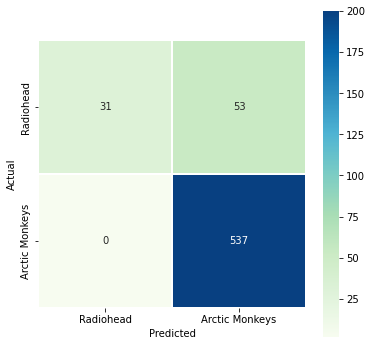

In [302]:
plot_heatmap(cm_LR)

### RandomForest

In [240]:
X = X_norm
y = df['artist']

In [241]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25)

In [242]:
model_RF = RandomForestClassifier()
model_RF.fit(X_train, y_train)
round(model_RF.score(X_train, y_train),2),round(model_LR.score(X_test, y_test),2)

(0.98, 0.91)

In [243]:
# cross validation
val = cross_val_score(model_RF, X_train, y_train, cv=5, scoring='accuracy')
print("cross validation accuracy: ", val.round(2))

cross validation accuracy:  [0.95 0.95 0.95 0.96 0.95]


In [244]:
y_pred_RF = model_RF.predict(X_test)
model_RF.predict_proba(X_train)

array([[0.00197802, 0.99802198],
       [0.        , 1.        ],
       [0.14361175, 0.85638825],
       ...,
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ]])

In [303]:
cm_RF, precision_RF, recall_RF = print_evaluations(y_test, y_pred_RF, 'RandomForest')

How does model RandomForest score:
The accuracy of the model is: 0.786
The precision of the model is: 0.863
The recall of the model is: 0.894
The f1-score of the model is: 0.878


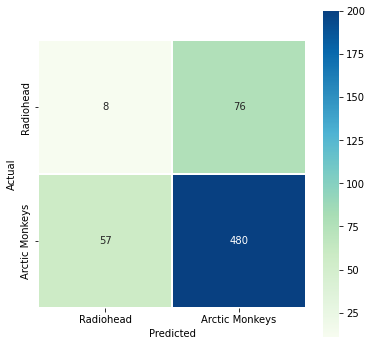

In [304]:
plot_heatmap(cm_RF)

### RandomForest + hyperparameters

In [246]:
model_RF1 = RandomForestClassifier(max_depth=5, n_estimators=10)
model_RF1.fit(X_train, y_train)
round(model_RF1.score(X_train, y_train),2),round(model_RF1.score(X_test, y_test),2)

(0.88, 0.86)

In [247]:
y_pred_RF1 = model_RF1.predict(X_test)

In [248]:
model_RF1.predict_proba(X_train)

array([[0.09677986, 0.90322014],
       [0.11160066, 0.88839934],
       [0.08962716, 0.91037284],
       ...,
       [0.08962716, 0.91037284],
       [0.09677986, 0.90322014],
       [0.11867425, 0.88132575]])

In [306]:
cm_RF1, precision_RF1, recall_RF1 = print_evaluations(y_test, y_pred_RF1, 'RandomForest1')

How does model RandomForest1 score:
The accuracy of the model is: 0.85
The precision of the model is: 0.863
The recall of the model is: 0.983
The f1-score of the model is: 0.919


### Naive Bayes

In [250]:
model_NB = MultinomialNB()
model_NB.fit(X_train, y_train)
round(model_NB.score(X_train, y_train),2),round(model_NB.score(X_test, y_test),2)

(0.94, 0.9)

In [251]:
y_pred_NB = model_NB.predict(X_test)

In [252]:
model_NB.predict_proba(X_train)

array([[0.10125013, 0.89874987],
       [0.00659825, 0.99340175],
       [0.14239656, 0.85760344],
       ...,
       [0.00980718, 0.99019282],
       [0.00134944, 0.99865056],
       [0.00144448, 0.99855552]])

In [309]:
cm_NB, precision_NB, recall_NB = print_evaluations(y_test, y_pred_NB, 'Naive Bayes')

How does model Naive Bayes score:
The accuracy of the model is: 0.818
The precision of the model is: 0.863
The recall of the model is: 0.939
The f1-score of the model is: 0.899


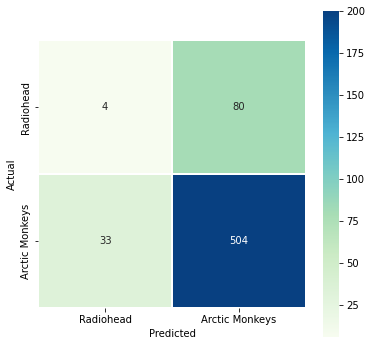

In [308]:
plot_heatmap(cm_NB)

### Oversampling

In [173]:
ros = RandomOverSampler(sampling_strategy={'Arctic Monkeys':1500})

In [174]:
X_ros, y_ros = ros.fit_resample(X_train, y_train)

In [175]:
np.unique(y_ros, return_counts=True)

(array(['Arctic Monkeys', 'Radiohead'], dtype=object), array([1500, 1600]))

In [177]:
model_RF.fit(X_ros, y_ros)

RandomForestClassifier()

In [178]:
ypred_ros = model_RF.predict(X_test)
ypred_ros

array(['Radiohead', 'Radiohead', 'Radiohead', 'Radiohead',
       'Arctic Monkeys', 'Radiohead', 'Arctic Monkeys', 'Radiohead',
       'Radiohead', 'Radiohead', 'Radiohead', 'Radiohead', 'Radiohead',
       'Radiohead', 'Arctic Monkeys', 'Radiohead', 'Radiohead',
       'Arctic Monkeys', 'Radiohead', 'Radiohead', 'Arctic Monkeys',
       'Radiohead', 'Radiohead', 'Radiohead', 'Arctic Monkeys',
       'Radiohead', 'Radiohead', 'Radiohead', 'Arctic Monkeys',
       'Arctic Monkeys', 'Radiohead', 'Radiohead', 'Radiohead',
       'Radiohead', 'Arctic Monkeys', 'Radiohead', 'Radiohead',
       'Radiohead', 'Radiohead', 'Arctic Monkeys', 'Radiohead',
       'Radiohead', 'Radiohead', 'Radiohead', 'Radiohead',
       'Arctic Monkeys', 'Radiohead', 'Radiohead', 'Arctic Monkeys',
       'Radiohead', 'Radiohead', 'Arctic Monkeys', 'Radiohead',
       'Arctic Monkeys', 'Arctic Monkeys', 'Arctic Monkeys', 'Radiohead',
       'Radiohead', 'Radiohead', 'Arctic Monkeys', 'Arctic Monkeys',
       'Radi

In [310]:
cm_ros, precision_ros, recall_ros = print_evaluations(y_test, ypred_ros, 'RandomOverSampler')

How does model RandomOverSampler score:
The accuracy of the model is: 0.668
The precision of the model is: 0.856
The recall of the model is: 0.741
The f1-score of the model is: 0.794


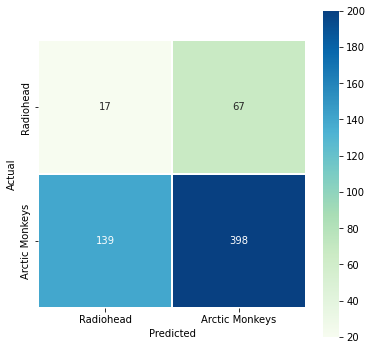

In [311]:
plot_heatmap(cm_ros)

#### SMOTE

In [179]:
sm = SMOTE(sampling_strategy={'Arctic Monkeys':1500}, 
           random_state=10)
X_smote, y_smote = sm.fit_resample(X_train, y_train)

In [180]:
np.unique(y_smote, return_counts=True)

(array(['Arctic Monkeys', 'Radiohead'], dtype=object), array([1500, 1600]))

In [137]:
model_RF.fit(X_smote, y_smote)
ypred_smote = model_RF.predict(X_test)

In [312]:
cm_smote, precision_smote, recall_smote = print_evaluations(y_test, ypred_smote, 'SMOTE')

How does model SMOTE score:
The accuracy of the model is: 0.665
The precision of the model is: 0.86
The recall of the model is: 0.732
The f1-score of the model is: 0.791


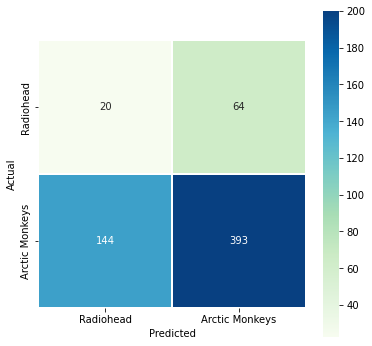

In [313]:
plot_heatmap(cm_smote)

### Undersampling

In [138]:
rus = RandomUnderSampler(sampling_strategy={"Radiohead":300})

In [139]:
X_rus, y_rus = rus.fit_resample(X_train, y_train)

In [140]:
model_RF.fit(X_rus, y_rus)

RandomForestClassifier()

In [141]:
y_pred_rus = model_RF.predict(X_test)
y_pred_rus

array(['Radiohead', 'Radiohead', 'Radiohead', 'Arctic Monkeys',
       'Radiohead', 'Radiohead', 'Arctic Monkeys', 'Arctic Monkeys',
       'Radiohead', 'Arctic Monkeys', 'Radiohead', 'Radiohead',
       'Arctic Monkeys', 'Arctic Monkeys', 'Radiohead', 'Arctic Monkeys',
       'Arctic Monkeys', 'Arctic Monkeys', 'Arctic Monkeys', 'Radiohead',
       'Radiohead', 'Radiohead', 'Arctic Monkeys', 'Radiohead',
       'Arctic Monkeys', 'Radiohead', 'Radiohead', 'Radiohead',
       'Radiohead', 'Radiohead', 'Radiohead', 'Radiohead', 'Radiohead',
       'Radiohead', 'Radiohead', 'Radiohead', 'Arctic Monkeys',
       'Radiohead', 'Radiohead', 'Arctic Monkeys', 'Radiohead',
       'Radiohead', 'Radiohead', 'Arctic Monkeys', 'Radiohead',
       'Arctic Monkeys', 'Radiohead', 'Arctic Monkeys', 'Arctic Monkeys',
       'Radiohead', 'Radiohead', 'Radiohead', 'Radiohead',
       'Arctic Monkeys', 'Radiohead', 'Radiohead', 'Arctic Monkeys',
       'Radiohead', 'Radiohead', 'Radiohead', 'Radiohead', 'R

In [314]:
cm_rus, precision_rus, recall_rus = print_evaluations(y_test, y_pred_rus, 'RandomUnderSampler')

How does model RandomUnderSampler score:
The accuracy of the model is: 0.652
The precision of the model is: 0.861
The recall of the model is: 0.713
The f1-score of the model is: 0.78


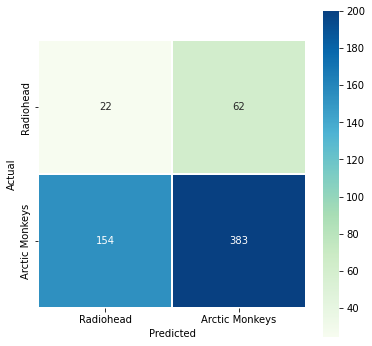

In [315]:
plot_heatmap(cm_rus)

#### NearMiss

In [73]:
nm = NearMiss(sampling_strategy={"Radiohead":300})
X_nm, y_nm = nm.fit_resample(X_train, y_train)
model_RF.fit(X_nm, y_nm)
y_pred_nm = model_RF.predict(X_test)
y_pred_nm

array(['Radiohead', 'Arctic Monkeys', 'Arctic Monkeys', 'Arctic Monkeys',
       'Arctic Monkeys', 'Radiohead', 'Arctic Monkeys', 'Radiohead',
       'Arctic Monkeys', 'Arctic Monkeys', 'Arctic Monkeys',
       'Arctic Monkeys', 'Radiohead', 'Arctic Monkeys', 'Radiohead',
       'Arctic Monkeys', 'Arctic Monkeys', 'Arctic Monkeys', 'Radiohead',
       'Arctic Monkeys', 'Arctic Monkeys', 'Radiohead', 'Arctic Monkeys',
       'Arctic Monkeys', 'Arctic Monkeys', 'Radiohead', 'Arctic Monkeys',
       'Radiohead', 'Radiohead', 'Radiohead', 'Arctic Monkeys',
       'Arctic Monkeys', 'Radiohead', 'Arctic Monkeys', 'Arctic Monkeys',
       'Radiohead', 'Radiohead', 'Arctic Monkeys', 'Arctic Monkeys',
       'Radiohead', 'Arctic Monkeys', 'Arctic Monkeys', 'Radiohead',
       'Radiohead', 'Radiohead', 'Radiohead', 'Arctic Monkeys',
       'Radiohead', 'Arctic Monkeys', 'Radiohead', 'Arctic Monkeys',
       'Arctic Monkeys', 'Arctic Monkeys', 'Arctic Monkeys', 'Radiohead',
       'Radiohead', 'R

In [316]:
cm_nm, precision_nm, recall_nm = print_evaluations(y_test, y_pred_nm, 'NearMiss')

How does model NearMiss score:
The accuracy of the model is: 0.407
The precision of the model is: 0.854
The recall of the model is: 0.38
The f1-score of the model is: 0.526


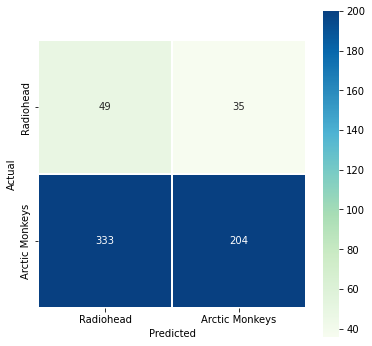

In [317]:
plot_heatmap(cm_nm)

### Prediction based on the input text

In [142]:
def predict(lyrics_input):
    song = [lyrics_input]
    counts = cv.transform(song)
    tfcounts = tf.transform(counts)
    
    lyrics_final= pd.DataFrame(counts.todense().round(2), columns=cv.get_feature_names_out())

    prediction = model_RF.predict(lyrics_final)
    print(prediction)

In [289]:
lyrics_input = input("Your lyrics: ")

#this is what you'll get when you mess with us
# i just wanted to be one of those ghosts you thought that you could forget

Your lyrics: this is what you'll get when you mess with us


In [290]:
predict(lyrics_input)

['Radiohead']


In [291]:
song = [lyrics_input]
counts = cv.transform(song)
tfcounts = tf.transform(counts)
model_RF.predict_proba(tfcounts).round(2)

array([[0.13, 0.87]])

In [292]:
model_RF.predict(tfcounts)

array(['Radiohead'], dtype=object)

### Summary

In [321]:
pd.DataFrame(
    {
        "precision": [
            precision_LR, precision_RF, precision_RF1, precision_NB,
            precision_ros, precision_smote, precision_rus, precision_nm
        ],
        "recall": [
            recall_LR,
            recall_RF,
            recall_RF1,
            recall_NB,
            recall_ros,
            recall_smote,
            recall_rus,
            recall_nm,
        ]
    },
    index=["LR", "RF", "RF1", "NB", "ROS", "SMOTE", "RUS", "NM"]
)

,precision,recall
LR,0.910169,1.000000
RF,0.863309,0.893855
RF1,0.862745,0.983240
NB,0.863014,0.938547
ROS,0.855914,0.741155
SMOTE,0.859956,0.731844
RUS,0.860674,0.713222
NM,0.853556,0.379888


### Word Cloud

In [154]:
with open("/Users/Varvara/spiced_working files/radiohead_songs/radiohead_karma+police.html", "r", encoding='utf-8') as f:
    html_string= f.read()
    
soup = BeautifulSoup(html_string)
text = soup.find(attrs={'class': 'lyric-body'}).text

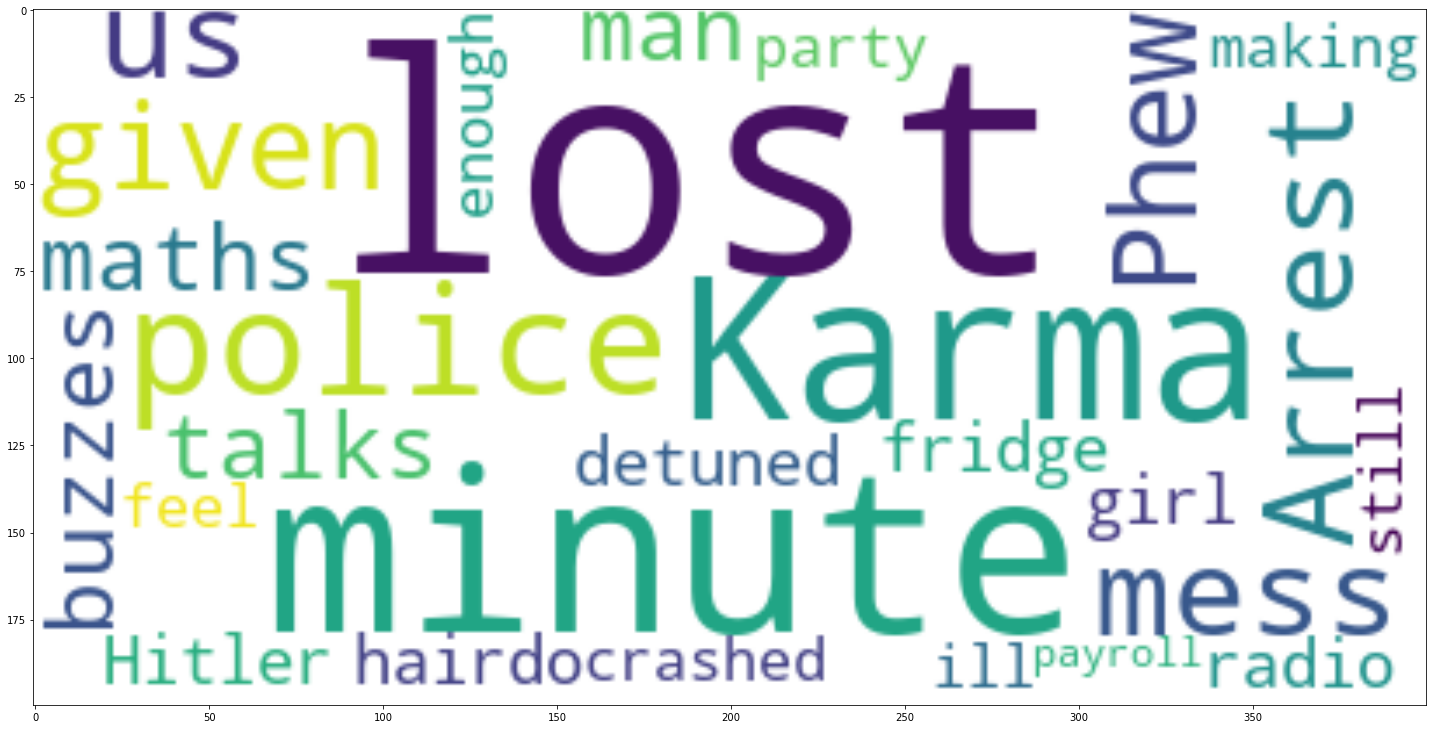

In [155]:
mask = np.zeros((500, 600, 3), np.uint8)
mask[150:350,150:350,:] = 255  # masked out area
cloud = wordcloud.WordCloud(background_color="white",
                max_words=50,
                #mask=mask,
                collocations=False,  # calculates frequencies
                contour_color='steelblue').generate(text)
                # stop words are removed!

plt.figure(figsize = (20,20))
plt.imshow(cloud, interpolation='bilinear')
plt.tight_layout(pad = 1.08)# important feature(without it there is a empty space in the middle)
plt.savefig('cloud.png')
plt.show()